In [1]:
import pandas as pd
import brickschema
import psycopg2
%matplotlib inline

In [2]:
g = brickschema.Graph().load_file("compiled-bldg2.ttl")

In [44]:
def sparql_to_df(g, q):
    res = g.query(q)
    df = pd.DataFrame.from_records(list(res))
    df = df.applymap(str)
    df.drop_duplicates(inplace=True)
    return df

def get_data(uuids, names):
    with psycopg2.connect("host=timescaledb port=5432 user=postgres password=mypassword") as conn:
        sql = "SELECT time, value, uuid FROM data WHERE uuid = ANY(%s)"
        df = pd.read_sql(sql, conn, params=(uuids,))
        df = df.pivot(columns='uuid', values='value', index='time')
        df = df.resample('15T').mean()
        df.columns = names
        return df

In [33]:
q = """
SELECT DISTINCT ?ahu ?sat ?sp ?satuuid ?spuuid WHERE {
   ?ahu  a  brick:AHU .
   ?ahu  brick:hasPoint  ?sat, ?sp .
   ?sat  a  brick:Supply_Air_Temperature_Sensor ;
         brick:timeseries [ brick:hasTimeseriesId ?satuuid ] .
   ?sp   a  brick:Supply_Air_Temperature_Setpoint ;
         brick:timeseries [ brick:hasTimeseriesId ?spuuid ]
}
"""
md = sparql_to_df(g, q)
md.head()

,0,1,2,3,4
0,http://buildsys.org/ontologies/BLDG2#AHU02,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,c31b36e4-594b-376a-8016-be2b9d83661b,2a7ef828-52fb-38a9-927c-305aba7be9f2
4,http://buildsys.org/ontologies/BLDG2#AHU03,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,fee42dba-f1c7-3c47-95d7-9625e8f1d61f,5191665d-2f27-3b12-9372-736cc23d5b9e
8,http://buildsys.org/ontologies/BLDG2#AHU05,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,cbb6b938-a584-3dfb-9c82-0d920cf37658,a4a26d1b-ee44-3b11-b86c-4c20c3697299
12,http://buildsys.org/ontologies/BLDG2#AHU01,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,http://buildsys.org/ontologies/BLDG2#BLDG2.AHU...,900b1843-eceb-36de-9466-cf6f901e387b,ccd88b2f-4e91-3fbc-bc73-9024ca24e99a


In [46]:
(ahu, sat, sp, satuuid, spuuid) in md.values[0]
df = get_data([satuuid, spuuid], ['sat', 'sp'])
print(df.head())

                            sat     sp
time                                  
2011-06-02 13:00:00+00:00   NaN  75.00
2011-06-02 13:15:00+00:00  75.0  74.90
2011-06-02 13:30:00+00:00  75.0  75.05
2011-06-02 13:45:00+00:00  75.0  74.80
2011-06-02 14:00:00+00:00  75.0  75.20


<AxesSubplot:xlabel='time'>

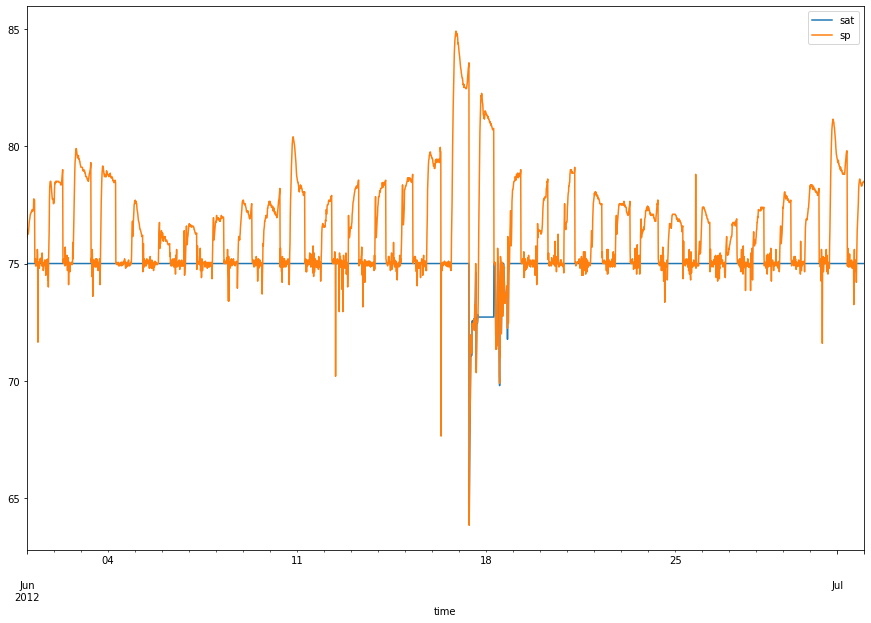

In [50]:
df['2012-06-01':'2012-07-01'].plot(figsize=(15,10))